# Hybrid Concern Matching Pilot

Bu notebook, kanonik hale getirilmiş ürün/ingredient verilerini kullanarak concern bazlı hibrit öneri sisteminin nasıl kurulduğunu ve değerlendirildiğini tüm adımlarıyla gösterir. Girdi olarak pipeline çıktıları (`Dataset_Pipeline/...`) ile ingredient açıklama dosyaları kullanılır; sonuçta sentetik kullanıcı profilleri üzerinde öneri listeleri ve paketleri üretip CSV olarak kaydederiz.

## 0. Setup

Bu bölümde tüm çalışma boyunca ihtiyaç duyacağımız kütüphaneleri, proje yollarını ve tekrar üretilebilirliği sağlayan sabitleri tek yerde topluyoruz. Ayrıca ilerleyen adımlarda davranışı kolayca kontrol edebilmek için yapılandırma (CONFIG) sözlüğünü tanımlıyoruz. Not defterindeki her iyileştirme bu yapılandırmayı okuyarak parametrik hale gelecek, böylece farklı senaryoları yeniden çalıştırmak zahmetsiz olacak.


In [1]:
import sys
import os
import ast
import json
import math
import random
import re
from pathlib import Path
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, ndcg_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit, cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler

PROJECT_ROOT = Path.cwd().resolve().parents[1]
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from Dataset_Pipeline import data_pipeline

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

random.seed(42)
np.random.seed(42)

CONCERNS = ['redness', 'eyebag', 'acne', 'oiliness', 'wrinkle', 'age', 'moisture']
DATA_ROOT = PROJECT_ROOT
PIPELINE_ROOT = PROJECT_ROOT / 'Dataset_Pipeline'

CONFIG = {
    'use_llm': False,
    'first_ingredient_max_products': 300,
    'first_ingredient_min_hits': 4,
    'description_model_min_samples': 120,
    'description_model_min_probability': 0.42,
    'description_model_max_labels': 2,
    'weight_eval_samples_per_concern': 150,
    'unknown_penalty_weight': 0.04,
    'name_hint_bonus': 1.0,
    'weight_strategies': ('harmonic', 'log'),
}


## 1. Load Normalised Data

Bu bölümde pipeline çıktılarından yalnızca analiz için gereken alanları okuyarak belleği verimli kullanıyoruz. Ingredient haritaları ile benzersiz ingredient listesini de yükleyip önden sıklık istatistikleri çıkarıyoruz; bu istatistikler hem yeni heuristikler hem de model özellikleri için temel teşkil edecek.


In [2]:
converters = {
    'ingredients_list_raw': ast.literal_eval,
    'ingredients_list_normalised': ast.literal_eval,
}

product_usecols = ['product_id', 'category', 'name', 'ingredients_list_normalised', 'ingredients_list_raw']
products = pd.read_csv(
    PIPELINE_ROOT / 'unified_products.csv',
    usecols=product_usecols,
    converters=converters,
)

products['ingredients_list_normalised'] = products['ingredients_list_normalised'].apply(
    lambda value: value if isinstance(value, list) else []
)
products['ingredients_list_raw'] = products['ingredients_list_raw'].apply(
    lambda value: value if isinstance(value, list) else []
)

ingredient_map = pd.read_csv(
    PIPELINE_ROOT / 'ingredient_normalisation_map.csv',
    usecols=['product_id', 'canonical'],
)
unique_ingredients = pd.read_csv(PIPELINE_ROOT / 'unique_ingredients.csv')

INGREDIENT_FREQUENCY = (
    ingredient_map.groupby('canonical')['product_id']
    .nunique()
    .to_dict()
)
GLOBAL_MAX_FREQUENCY = max(INGREDIENT_FREQUENCY.values())

print(f'Products: {len(products):,}')
print(f'Mapping rows: {len(ingredient_map):,}')
print(f'Unique ingredients: {len(unique_ingredients):,}')
products.head(3)


Products: 16,556
Mapping rows: 364,128
Unique ingredients: 18,018


,product_id,category,name,ingredients_list_raw,ingredients_list_normalised
0,0,facial cleanser,Grace + Tonic Botanical Beauty Cleansing Mud (...,"[WATER, ALOE BARBADENSIS LEAF JUICE*, CAPRYLYL...","[water, aloe barbadensis leaf juice, caprylyl ..."
1,1,facial cleanser,Murad Hydration AHA/BHA Exfoliating Cleanser,"[Water (Aqua), Sodium Laureth Sulfate, Cocamid...","[water, sodium laureth sulfate, cocamidopropyl..."
2,2,facial cleanser,Purity One Step Mattifying Facial Cleanser,"[AQUA/WATER/EAU, SODIUM LAUROAMPHOACETATE, SOD...","[water, sodium cocoamphoacetate, sodium tridec..."


In [3]:
ARTIFACT_DIR = (Path.cwd() / '..' / 'artifacts' / 'features').resolve()
PRECOMPUTED_FEATURES = False

def _read_artifact_table(name):
    parquet_path = ARTIFACT_DIR / f"{name}.parquet"
    csv_path = ARTIFACT_DIR / f"{name}.csv"
    if parquet_path.exists():
        return pd.read_parquet(parquet_path)
    if csv_path.exists():
        return pd.read_csv(csv_path)
    raise FileNotFoundError(f"'{name}' artefakti bulunamadı: {parquet_path} veya {csv_path}")

if ARTIFACT_DIR.exists():
    try:
        product_profile_df = _read_artifact_table('product_profiles')
        weights_df = _read_artifact_table('ingredient_concern_weights')
        ingredient_concern_weights = {}
        for row in weights_df.itertuples(index=False):
            ingredient_concern_weights.setdefault(row.ingredient, {})[row.concern] = float(row.weight)
        candidate_path = ARTIFACT_DIR / 'ingredient_concern_candidates.json'
        if candidate_path.exists():
            with candidate_path.open(encoding='utf-8') as handle:
                candidate_data = json.load(handle)
            ingredient_concern_candidates = {token: set(values) for token, values in candidate_data.items()}
        INGREDIENT_RARITY = {
            ingredient: 1.0 / np.log1p(INGREDIENT_FREQUENCY.get(ingredient, 1))
            for ingredient in ingredient_concern_weights.keys()
        }
        UNKNOWN_INGREDIENTS = {
            ingredient for ingredient in unique_ingredients['ingredient']
            if ingredient not in ingredient_concern_weights
        }
        selected_positional_strategy = 'log'
        strategy_evaluation = pd.DataFrame()
        PRECOMPUTED_FEATURES = True
        print(f"Artefaktlar yüklendi → {ARTIFACT_DIR}")
    except Exception as exc:
        print(f"Artefaktlar yüklenirken hata oluştu, notebook hesaplamaya devam edecek: {exc}")
else:
    print(f"Artefakt dizini bulunamadı: {ARTIFACT_DIR}")


Artefaktlar yüklendi → C:\Users\barut\OneDrive\Desktop\BlueSenseRecommendation\experiments_update\artifacts\features


## 2. Ingredient Knowledge Base

Bu kısımda ingredient → concern eşleştirmesini, farklı bilgi kaynaklarını ardışık şekilde kullanarak genişletiyoruz. Excel’deki manuel etiketler, JSON açıklamalarından çıkarılan anahtar kelimeler ve kategori/ürün tabanlı çıkarımlar birleşerek daha dolu bir bilgi tabanı oluşturuyor; böylece modellerimiz LLM’e gerek kalmadan daha kapsayıcı hale geliyor.


In [4]:
ingredient_concern_df = pd.read_excel(DATA_ROOT / 'ingredient_concern_map.xlsx')
with open(DATA_ROOT / 'about_ingredients.json', 'r', encoding='utf-8') as fp:
    about_ingredients = json.load(fp)
about_lookup = {data_pipeline.normalise_token(item['ingredient']): item['description'] for item in about_ingredients}

def normalise_phrase(text: str) -> str:
    if not isinstance(text, str):
        return ''
    return data_pipeline.normalise_token(text)

KEYWORD_HINTS = {
    'redness': ['redness', 'inflammation', 'rosacea', 'calm', 'soothe'],
    'eyebag': ['eye bag', 'eyebag', 'puff', 'dark circle', 'blephar'],
    'acne': ['acne', 'blemish', 'comedone', 'pimple'],
    'oiliness': ['sebum', 'oil', 'matte', 'sebum control'],
    'wrinkle': ['wrinkle', 'collagen', 'elasticity', 'firming'],
    'age': ['anti aging', 'antiage', 'age spot', 'fine line'],
    'moisture': ['moisture', 'hydration', 'humectant', 'hydrating'],
}

CATEGORY_CONCERN_HINTS = {
    'anti aging': ['age', 'wrinkle'],
    'around eye cream': ['eyebag', 'wrinkle', 'redness'],
    'bb cream': ['redness', 'moisture', 'age'],
    'cc cream': ['redness', 'moisture', 'age'],
    'facial cleanser': ['acne', 'oiliness', 'redness'],
    'facial moisturizer treatment': ['moisture', 'age', 'wrinkle'],
    'mask': ['moisture', 'acne', 'oiliness'],
    'makeup remover': ['redness', 'moisture'],
    'serums essences': ['age', 'wrinkle', 'moisture'],
    'skin fading lightener': ['age', 'redness'],
    'toners astringents': ['oiliness', 'redness', 'acne'],
    'pore strips': ['acne', 'oiliness'],
    'oil controller': ['oiliness', 'acne'],
}

NAME_HINTS = {
    'acne': ['acne'],
    'blemish': ['acne'],
    'oil': ['oiliness'],
    'matte': ['oiliness'],
    'pore': ['oiliness', 'acne'],
    'wrinkle': ['wrinkle'],
    'age': ['age'],
    'youth': ['age'],
    'lift': ['age', 'wrinkle'],
    'firm': ['wrinkle'],
    'moist': ['moisture'],
    'hydra': ['moisture'],
    'soothe': ['redness'],
    'calm': ['redness'],
    'repair': ['age', 'wrinkle'],
    'bright': ['age', 'redness'],
    'eye': ['eyebag'],
    'sleep': ['eyebag'],
}

problem_keyword_map = {concern: set(keywords) for concern, keywords in KEYWORD_HINTS.items()}

llm_available = False
openai_client = None
print('LLM integration disabled for this run.')


LLM integration disabled for this run.

### 2.1 Excel Kaynağındaki Concern Eşleşmelerini Ayrıştırma

Excel dosyasındaki serbest metin alanları normalize edilip tokenize ediliyor. Alias dönüşümleri (ör. “moisturize” → “moisture”) ve eş anlamlı eşleştirmeleri uygulanarak `ingredient_concern_candidates` sözlüğünün ilk versiyonu üretiliyor.


In [5]:

def extract_concerns_from_text(text: str) -> list[str]:
    text = (text or '').lower()
    matches = []
    for concern in CONCERNS:
        if concern in text:
            matches.append(concern)
    keyword_aliases = {
        'moisturize': 'moisture',
        'moisturise': 'moisture',
        'eye bag': 'eyebag',
        'eye bags': 'eyebag',
        'dry eye': 'eyebag',
    }
    for alias, concern in keyword_aliases.items():
        if alias in text and concern not in matches:
            matches.append(concern)
    return matches


def split_ingredient_candidates(text: str) -> list[str]:
    if not isinstance(text, str):
        return []
    # Replace connectors with comma then split
    filtered = text.replace('/', ',').replace('\\', ',')
    filtered = filtered.replace(' and ', ',').replace(' or ', ',')
    filtered = filtered.replace('(', ' ').replace(')', ' ')
    parts = [normalise_phrase(part) for part in filtered.split(',')]
    return [part for part in parts if part]

ingredient_concern_candidates = defaultdict(set)
for _, row in ingredient_concern_df.iterrows():
    concerns = extract_concerns_from_text(row['skin problem'])
    if not concerns:
        continue
    for candidate in split_ingredient_candidates(row['ingredients']):
        for concern in concerns:
            ingredient_concern_candidates[candidate].add(concern)

len(ingredient_concern_candidates)


240

### 2.2 Ingredient Açıklamalarından Anahtar Kelime Çıkarmak

JSON açıklamaları üzerinden concern’e özgü anahtar kelimeleri tarayarak Excel’de yer almayan ingredient’lara heuristik etiketler ekliyoruz. Bu adım özellikle uzun açıklamalı ama manuel haritada bulunmayan maddeler için önemli bir kapsama artışı sağlıyor.


In [6]:
missing_after_descriptions = 0
for canonical_name in unique_ingredients['ingredient']:
    name_raw = str(canonical_name)
    name_norm = normalise_phrase(name_raw)
    if not name_norm:
        continue

    if ingredient_concern_candidates.get(name_norm):
        continue

    description = (
        about_lookup.get(name_norm)
        or about_lookup.get(name_raw)
        or ''
    )
    if not isinstance(description, str):
        if description:
            description = str(description)
        else:
            missing_after_descriptions += 1
            continue

    desc_norm = description.lower()
    matches = [
        concern
        for concern, keywords in KEYWORD_HINTS.items()
        if any(keyword in desc_norm for keyword in keywords)
    ]
    if matches:
        for concern in matches:
            ingredient_concern_candidates[name_norm].add(concern)
    else:
        missing_after_descriptions += 1

print('Ingredients with concern hints:', len(ingredient_concern_candidates))
print('Still unresolved after descriptions:', missing_after_descriptions)


Ingredients with concern hints: 736
Still unresolved after descriptions: 17405


### 2.3 Kategori Bazlı İlk Ingredient Çıkarımı

Kategori–concern eşleşmesinden emin olduğumuz ürünleri kullanarak ingredient sözlüğünü further genişletiyoruz. Her concern için aynı sayıda ürün seçiliyor, ürünlerin ilk (su hariç) ingredient'ı ilgili concern’e ekleniyor ve tekrar eden adaylar eşitlik için sınırlandırılıyor. Böylece, manuel haritada yer almayan ancak kategori tanımı güçlü olan ürünlerden ekstra sinyal çıkarıyoruz.

In [7]:
concern_primary_categories = {
    concern: [
        category
        for category, hints in CATEGORY_CONCERN_HINTS.items()
        if hints and hints[0] == concern
    ]
    for concern in CONCERNS
}

for concern in CONCERNS:
    if not concern_primary_categories[concern]:
        concern_primary_categories[concern] = [
            category for category, hints in CATEGORY_CONCERN_HINTS.items() if concern in hints
        ]

concern_product_frames = {
    concern: products[products['category'].isin(categories)].copy()
    for concern, categories in concern_primary_categories.items()
}

non_empty_counts = [len(df) for df in concern_product_frames.values() if len(df) > 0]
if non_empty_counts:
    per_concern_limit = min(min(non_empty_counts), CONFIG['first_ingredient_max_products'])
else:
    per_concern_limit = 0

first_seed_counts: dict[str, Counter] = defaultdict(Counter)
first_seed_assignments = 0
first_seed_new_ingredients = 0

for concern, frame in concern_product_frames.items():
    if frame.empty or per_concern_limit == 0:
        continue
    sampled = (
        frame.sort_values('product_id')
        .head(per_concern_limit)
        .reset_index(drop=True)
    )
    for _, row in sampled.iterrows():
        ingredients = row['ingredients_list_normalised']
        if not ingredients:
            continue
        primary = None
        for token in ingredients:
            if token not in data_pipeline.WATER_WORDS:
                primary = token
                break
        if primary is None:
            continue
        first_seed_counts[primary][concern] += 1
        first_seed_assignments += 1

for ingredient, counter in first_seed_counts.items():
    for concern, hits in counter.items():
        if hits >= CONFIG['first_ingredient_min_hits']:
            before = len(ingredient_concern_candidates.get(ingredient, []))
            ingredient_concern_candidates[ingredient].add(concern)
            after = len(ingredient_concern_candidates.get(ingredient, []))
            if before == 0 and after > 0:
                first_seed_new_ingredients += 1

first_seed_summary = (
    pd.DataFrame(
        (
            {'ingredient': ingredient, 'concern': concern, 'hit_count': hits}
            for ingredient, counter in first_seed_counts.items()
            for concern, hits in counter.items()
            if hits >= CONFIG['first_ingredient_min_hits']
        )
    )
    .sort_values(['concern', 'hit_count', 'ingredient'], ascending=[True, False, True])
    .reset_index(drop=True)
)

print(
    f'Kategori bazlı çıkarım {first_seed_new_ingredients} yeni ingredient için '
    f'{first_seed_assignments} adet ilk-sıra gözlemi işledi.'
)
first_seed_summary.head(10)

Kategori bazlı çıkarım 26 yeni ingredient için 2099 adet ilk-sıra gözlemi işledi.

,ingredient,concern,hit_count
0,glycerin,acne,32
1,sodium laureth sulfate,acne,18
2,aloe barbadensis leaf juice,acne,12
3,cocamidopropyl betaine,acne,11
4,sodium c14-16 olefin sulfonate,acne,9
5,caprylic capric triglyceride,acne,8
6,decyl glucoside,acne,8
7,purified water,acne,7
8,cocamidopropyl hydroxysultaine,acne,6
9,cocos nucifera coconut oil,acne,6


### 2.4 TF-IDF Destekli Ingredient Sınıflandırması

Ingredient açıklamalarından TF-IDF özellikleri çıkarıp çoklu etiketli lojistik regresyon modeli eğitiyoruz. Model güven eşiğini aşan tahminleri, daha önce eşleşmemiş ingredient'lara concern etiketi olarak ekliyoruz; böylece LLM kullanmadan kapsama alanını ciddi biçimde genişletebiliyoruz.

In [8]:
description_training_rows = []
for ingredient, concerns in ingredient_concern_candidates.items():
    description = about_lookup.get(ingredient)
    if not concerns or not isinstance(description, str) or not description.strip():
        continue
    description_training_rows.append(
        {
            'ingredient': ingredient,
            'description': description,
            'concerns': sorted(concerns),
        }
    )

description_training_df = pd.DataFrame(description_training_rows)
if len(description_training_df) >= CONFIG['description_model_min_samples']:
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.85)
    X_train_desc = vectorizer.fit_transform(description_training_df['description'])
    mlb = MultiLabelBinarizer(classes=CONCERNS)
    y_train_desc = mlb.fit_transform(description_training_df['concerns'])

    desc_classifier = OneVsRestClassifier(
        LogisticRegression(max_iter=400, class_weight='balanced')
    )
    desc_classifier.fit(X_train_desc, y_train_desc)

    tfidf_new_ingredients = 0
    tfidf_total_labels = 0
    for ingredient in unique_ingredients['ingredient']:
        if ingredient_concern_candidates.get(ingredient):
            continue
        description = about_lookup.get(ingredient)
        if not isinstance(description, str) or not description.strip():
            continue
        probs = desc_classifier.predict_proba(vectorizer.transform([description]))[0]
        top_indices = np.argsort(probs)[::-1][:CONFIG['description_model_max_labels']]
        accepted = [
            mlb.classes_[idx]
            for idx in top_indices
            if probs[idx] >= CONFIG['description_model_min_probability']
        ]
        if accepted:
            for concern in accepted:
                ingredient_concern_candidates[ingredient].add(concern)
            tfidf_new_ingredients += 1
            tfidf_total_labels += len(accepted)
    print(
        f'TF-IDF modeli {tfidf_new_ingredients} ingredient için '
        f'{tfidf_total_labels} yeni concern etiketi önerdi.'
    )
else:
    print('TF-IDF modeli için yeterli eğitim örneği olmadığı için adım atlandı.')

TF-IDF modeli 340 ingredient için 522 yeni concern etiketi önerdi.


#### 2.5 Harici INCI Sözlüğü Entegrasyonu İçin Yol Haritası

Bu çalışmada dış veri kullanmıyoruz; ancak ileride güvenilir bir INCI sözlüğü temin edildiğinde aşağıdaki adımlar izlenebilir:
- Sözlükten ingredient → concern mapping’i JSON/CSV formatında içeri aktarıp `ingredient_concern_candidates` sözlüğünü güncellemek.
- Harici eşleştirme ile dahili çıkarımların çakışması halinde güven puanı yüksek olan kaynağı tercih etmek veya ağırlıklı ortalama almak.
- Sözlükte yer almayan ingredient'lara küçük bir “bilinmeyen” cezası uygulayarak skor fonksiyonunda daha düşük puan verilmesini sağlamak (aşağıdaki skor bileşenlerinde bu ceza mekanizması uygulanmıştır).

Bu strateji, LLM’e gerek kalmadan kapsamı genişletmek ve sahaya özgü kurallar eklemek için güvenli bir yol sağlar.

### 2.6 Optional LLM Enrichment (Pasif)

LLM tabanlı zenginleştirme bu çalışma boyunca kapalı tutuluyor. Yapılandırma üzerinden etkinleştirilmediği sürece herhangi bir API çağrısı yapılmıyor; kod bloğu yalnızca gelecekteki olası entegrasyonlar için rehber niteliği taşıyor.



LLM_CACHE_PATH = Path('Experiments/Hybrid_Concern_Test/cache/ingredient_concern_llm.json')

llm_enabled = bool(os.getenv('OPENAI_API_KEY'))
openai_client = None
if llm_enabled:
    try:
        from openai import OpenAI
        openai_client = OpenAI()
    except Exception:
        llm_enabled = False
        print('OpenAI client could not be initialised; skipping LLM enrichment.')
else:
    print('OPENAI_API_KEY not set; skipping LLM enrichment.')


def query_llm_for_concerns(ingredient: str, description: str | None = None) -> list[str]:
    if not llm_enabled or openai_client is None:
        return []
    concern_list = ', '.join(CONCERNS)
    prompt = (
        f"Given the cosmetic ingredient '{ingredient}', list which of the following skin concerns it primarily helps with: {concern_list}. "
        "Use the ingredient description if provided. Respond with a JSON list of concern strings."
    )
    if description:
        prompt += "\nDescription: {}".format(description[:800])
    try:
        response = openai_client.responses.create(
            model='gpt-4.1',
            input=prompt,
        )
        content = response.output[0].content[0].text
        parsed = json.loads(content)
        return [normalise_phrase(item) for item in parsed if normalise_phrase(item) in CONCERNS]
    except Exception:
        return []

if llm_enabled and openai_client is not None:
    LLM_CACHE_PATH.parent.mkdir(parents=True, exist_ok=True)
    if LLM_CACHE_PATH.exists():
        llm_cache = json.load(LLM_CACHE_PATH.open('r', encoding='utf-8'))
    else:
        llm_cache = {}

    unresolved = [
        ing for ing in unique_ingredients['ingredient']
        if not ingredient_concern_candidates.get(ing)
    ]
    missing = [ing for ing in unresolved if ing not in llm_cache]

    enriched = 0
    for ingredient in missing:
        desc = about_lookup.get(ingredient)
        llm_concerns = query_llm_for_concerns(ingredient, desc)
        llm_cache[ingredient] = llm_concerns
        if llm_concerns:
            for concern in llm_concerns:
                ingredient_concern_candidates[ingredient].add(concern)
            enriched += 1

    for ingredient in unresolved:
        cached = llm_cache.get(ingredient, [])
        for concern in cached:
            ingredient_concern_candidates[ingredient].add(concern)

    json.dump(llm_cache, LLM_CACHE_PATH.open('w', encoding='utf-8'), ensure_ascii=False, indent=2)
    print(f'LLM enriched ingredients (new queries): {enriched}')
else:
    print('LLM enrichment skipped. Cache not updated.')

## 3. Ingredient Concern Weights

Bu adım ingredient sıralarını kullanarak concern olasılıkları üretir. İki farklı pozisyon ağırlığı (armoniklik ve logaritmik sönümleme) denenir, kategori odaklı ürünler üzerinde hangi stratejinin daha iyi ayırt ettiğini ölçülür ve en yüksek skoru alan yöntem seçilir. Böylece modelleme aşamasına, kategori sinyaliyle tutarlı ve dengeli bir ingredient haritası aktarılır.


In [9]:
POSITIONAL_WEIGHT_FUNCTIONS = {
    'harmonic': lambda n: np.array([1.0 / (idx + 1) for idx in range(n)], dtype=float),
    'log': lambda n: np.array([1.0 / np.log(idx + 2) for idx in range(n)], dtype=float),
}


def _normalise_weights(raw: np.ndarray) -> np.ndarray:
    if raw.size == 0:
        return raw
    total = raw.sum()
    if total == 0:
        return np.zeros_like(raw)
    return raw / total


def _evaluate_weight_strategy(weights_map: dict[str, dict[str, float]]) -> float:
    margins: list[float] = []
    for concern, frame in concern_product_frames.items():
        if frame.empty:
            continue
        limit = min(len(frame), CONFIG['weight_eval_samples_per_concern'])
        sample = frame.head(limit)
        for ingredients in sample['ingredients_list_normalised']:
            if not ingredients:
                continue
            target_score = sum(weights_map.get(token, {}).get(concern, 0.0) for token in ingredients)
            other_scores = []
            for other_concern in CONCERNS:
                if other_concern == concern:
                    continue
                other_scores.append(
                    sum(weights_map.get(token, {}).get(other_concern, 0.0) for token in ingredients)
                )
            opponent = np.mean(other_scores) if other_scores else 0.0
            margins.append(target_score - opponent)
    if not margins:
        return 0.0
    return float(np.mean(margins))


if globals().get('PRECOMPUTED_FEATURES'):
    strategy_evaluation = pd.DataFrame()
    print('Ingredient concern weightleri artefaktlardan yüklendi; strateji taraması atlandı.')
else:
    strategy_weight_maps: dict[str, dict[str, dict[str, float]]] = {}
    strategy_scores: dict[str, float] = {}
    strategy_coverage: dict[str, int] = {}

    for strategy in CONFIG['weight_strategies']:
        positional_fn = POSITIONAL_WEIGHT_FUNCTIONS[strategy]
        ingredient_weight_accumulator: dict[str, Counter] = defaultdict(Counter)

        for _, row in products.iterrows():
            ingredients = row['ingredients_list_normalised']
            if not ingredients:
                continue
            weights = _normalise_weights(positional_fn(len(ingredients)))
            for idx, ingredient in enumerate(ingredients):
                concerns = ingredient_concern_candidates.get(ingredient)
                if not concerns:
                    continue
                share = weights[idx]
                portion = share / len(concerns)
                accumulator_row = ingredient_weight_accumulator[ingredient]
                for concern in concerns:
                    accumulator_row[concern] += portion

        ingredient_concern_weights_candidate = {}
        for ingredient, counter in ingredient_weight_accumulator.items():
            total = sum(counter.values())
            if total == 0:
                continue
            ingredient_concern_weights_candidate[ingredient] = {
                concern: value / total for concern, value in counter.items()
            }

        strategy_weight_maps[strategy] = ingredient_concern_weights_candidate
        strategy_scores[strategy] = _evaluate_weight_strategy(ingredient_concern_weights_candidate)
        strategy_coverage[strategy] = len(ingredient_concern_weights_candidate)

    strategy_evaluation = (
        pd.DataFrame(
            {
                'strategy': list(strategy_scores.keys()),
                'margin_score': list(strategy_scores.values()),
                'ingredient_coverage': list(strategy_coverage.values()),
            }
        )
        .sort_values('margin_score', ascending=False)
        .reset_index(drop=True)
    )

    selected_positional_strategy = strategy_evaluation.iloc[0]['strategy']
    ingredient_concern_weights = strategy_weight_maps[selected_positional_strategy]

    INGREDIENT_RARITY = {
        ingredient: 1.0 / np.log1p(INGREDIENT_FREQUENCY.get(ingredient, 1))
        for ingredient in ingredient_concern_weights.keys()
    }
    UNKNOWN_INGREDIENTS = {
        ingredient for ingredient in unique_ingredients['ingredient'] if ingredient not in ingredient_concern_weights
    }

    print('Pozisyon stratejisi değerlendirme tablosu:')
strategy_evaluation


Ingredient concern weightleri artefaktlardan yüklendi; strateji taraması atlandı.


""


## 4. Product Concern Profiles

Bu bölüm, ingredient/kategori/ürün adı sinyallerini birleştirerek her ürün için concern vektörü çıkarır. Ingredient frekansı ile nadirlik ağırlıkları uygulanır, bilinmeyen ingredient oranı hesaplanır ve genişletilmiş isim ipuçlarıyla ek semantik sinyaller üretilir. Sonuç olarak hem model eğitiminde hem de öneri skorlamasında kullanılacak zengin özellik tablosu elde edilir.


In [10]:
CATEGORY_PRIMARY_CONCERN = {
    category: hints[0] if hints else None
    for category, hints in CATEGORY_CONCERN_HINTS.items()
}

NAME_HINT_TOKENS = {
    'acne': {'concerns': ['acne']},
    'blemish': {'concerns': ['acne']},
    'pimple': {'concerns': ['acne']},
    'purifying': {'concerns': ['acne', 'oiliness']},
    'clarifying': {'concerns': ['acne', 'oiliness']},
    'sebum': {'concerns': ['oiliness']},
    'matte': {'concerns': ['oiliness']},
    'oil-control': {'concerns': ['oiliness']},
    'retinol': {'concerns': ['wrinkle', 'age']},
    'collagen': {'concerns': ['wrinkle', 'age']},
    'firming': {'concerns': ['wrinkle']},
    'lifting': {'concerns': ['wrinkle', 'age']},
    'wrinkle': {'concerns': ['wrinkle']},
    'antiaging': {'concerns': ['age', 'wrinkle']},
    'youth': {'concerns': ['age']},
    'bright': {'concerns': ['age', 'redness']},
    'even': {'concerns': ['age']},
    'radiance': {'concerns': ['age', 'moisture']},
    'calming': {'concerns': ['redness']},
    'soothing': {'concerns': ['redness']},
    'repair': {'concerns': ['age', 'wrinkle']},
    'comfort': {'concerns': ['redness']},
    'plump': {'concerns': ['moisture', 'wrinkle']},
    'hydrate': {'concerns': ['moisture']},
    'hydrating': {'concerns': ['moisture']},
    'dewy': {'concerns': ['moisture']},
    'sleep': {'concerns': ['eyebag']},
    'eye': {'concerns': ['eyebag']},
    'night': {'concerns': ['eyebag', 'wrinkle']},
    'defense': {'concerns': ['age', 'redness']},
}

NAME_HINT_PHRASES = {
    'dark circle': ['eyebag'],
    'fine line': ['wrinkle', 'age'],
    'anti wrinkle': ['wrinkle', 'age'],
    'anti redness': ['redness'],
    'spot corrector': ['age'],
    'oil control': ['oiliness'],
    'oil blotting': ['oiliness'],
    'blemish control': ['acne'],
    'pore minimizing': ['acne', 'oiliness'],
    'cooling eye': ['eyebag'],
}


def _build_name_vector(name: str) -> dict[str, float]:
    vector = {concern: 0.0 for concern in CONCERNS}
    if not isinstance(name, str) or not name:
        return vector
    normalized = name.lower()
    tokens = re.findall(r"[a-z0-9-]+", normalized)
    for token in tokens:
        mapping = NAME_HINT_TOKENS.get(token)
        if not mapping:
            continue
        for concern in mapping['concerns']:
            vector[concern] += mapping.get('weight', 1.0)
    for phrase, concerns in NAME_HINT_PHRASES.items():
        if phrase in normalized:
            for concern in concerns:
                vector[concern] += CONFIG['name_hint_bonus']
    total = sum(vector.values())
    if total > 0:
        vector = {concern: value / total for concern, value in vector.items()}
    return vector


def build_signal_vector(seed: list[str] | None = None) -> dict[str, float]:
    data = {concern: 0.0 for concern in CONCERNS}
    if not seed:
        return data
    for concern in seed:
        if concern in data:
            data[concern] += 1.0
    total = sum(data.values())
    if total > 0:
        data = {concern: value / total for concern, value in data.items()}
    return data


if globals().get('PRECOMPUTED_FEATURES'):
    print('Ürün profili artefaktlardan yüklendi; yeniden hesaplama yapılmadı.')
else:
    product_profiles = []
    positional_function = POSITIONAL_WEIGHT_FUNCTIONS[selected_positional_strategy]

    for row in products.itertuples(index=False):
        tokens = getattr(row, 'ingredients_list_normalised', [])
        weights = _normalise_weights(positional_function(len(tokens)))

        ingredient_vector = {concern: 0.0 for concern in CONCERNS}
        rare_vector = {concern: 0.0 for concern in CONCERNS}
        unknown_count = 0

        for idx, ingredient in enumerate(tokens):
            concern_weights = ingredient_concern_weights.get(ingredient)
            if not concern_weights:
                unknown_count += 1
                continue
            share = weights[idx] if idx < len(weights) else 0.0
            rarity_multiplier = INGREDIENT_RARITY.get(ingredient, 1.0)
            for concern, value in concern_weights.items():
                contribution = share * value
                ingredient_vector[concern] += contribution
                rare_vector[concern] += contribution * rarity_multiplier

        ingredient_total = sum(ingredient_vector.values())
        if ingredient_total > 0:
            ingredient_vector = {
                concern: value / ingredient_total for concern, value in ingredient_vector.items()
            }
        rare_total = sum(rare_vector.values())
        if rare_total > 0:
            rare_vector = {
                concern: value / rare_total for concern, value in rare_vector.items()
            }

        category = getattr(row, 'category')
        category_vector = build_signal_vector(CATEGORY_CONCERN_HINTS.get(category, []))
        name_vector = _build_name_vector(getattr(row, 'name'))

        aggregate_vector = {concern: 0.0 for concern in CONCERNS}
        for concern in CONCERNS:
            aggregate_vector[concern] = (
                ingredient_vector.get(concern, 0.0)
                + category_vector.get(concern, 0.0)
                + name_vector.get(concern, 0.0)
            )
        aggregate_total = sum(aggregate_vector.values())
        if aggregate_total > 0:
            aggregate_vector = {
                concern: value / aggregate_total for concern, value in aggregate_vector.items()
            }

        dominant = max(aggregate_vector, key=aggregate_vector.get)
        product_profiles.append(
            {
                'product_id': getattr(row, 'product_id'),
                'category': category,
                'name': getattr(row, 'name'),
                **{f'ing_{c}': ingredient_vector.get(c, 0.0) for c in CONCERNS},
                **{f'cat_{c}': category_vector.get(c, 0.0) for c in CONCERNS},
                **{f'name_{c}': name_vector.get(c, 0.0) for c in CONCERNS},
                **{f'rare_{c}': rare_vector.get(c, 0.0) for c in CONCERNS},
                **{f'total_{c}': aggregate_vector.get(c, 0.0) for c in CONCERNS},
                'unknown_ratio': unknown_count / max(len(tokens), 1),
                'dominant_concern': dominant,
            }
        )

    product_profile_df = pd.DataFrame(product_profiles)
    product_profile_df.head(3)


Ürün profili artefaktlardan yüklendi; yeniden hesaplama yapılmadı.


## 5. Balanced Train/Test Split

Ürün profillerini concern etiketlerine göre gruplayıp stratified shuffle split ile eğitim/test kümeleri oluşturuyoruz. Her concern’in her iki sette de temsil edildiğinden emin olmak için eksik kalan sınıflar manuel olarak dengeleniyor.


In [11]:
valid_profiles = product_profile_df[product_profile_df['dominant_concern'].isin(CONCERNS)].copy()
counts = valid_profiles['dominant_concern'].value_counts().sort_index()
print('Counts per concern:')
print(counts)

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices, test_indices = next(splitter.split(valid_profiles, valid_profiles['dominant_concern']))
train_df = valid_profiles.iloc[train_indices].reset_index(drop=True)
test_df = valid_profiles.iloc[test_indices].reset_index(drop=True)

missing_in_test = set(CONCERNS) - set(test_df['dominant_concern'].unique())
if missing_in_test:
    for concern in missing_in_test:
        candidates = train_df[train_df['dominant_concern'] == concern]
        if candidates.empty:
            continue
        take_row = candidates.iloc[[0]]
        train_df = train_df.drop(take_row.index).reset_index(drop=True)
        test_df = pd.concat([test_df, take_row], ignore_index=True)

print(f'Train size: {len(train_df)} | Test size: {len(test_df)}')
print('Train distribution:')
print(train_df['dominant_concern'].value_counts().sort_index())
print('Test distribution:')
print(test_df['dominant_concern'].value_counts().sort_index())


Counts per concern:
dominant_concern
acne        1324
age          444
eyebag      1186
moisture    8094
oiliness    2585
redness      959
wrinkle     1964
Name: count, dtype: int64
Train size: 13244 | Test size: 3312
Train distribution:
dominant_concern
acne        1059
age          355
eyebag       949
moisture    6475
oiliness    2068
redness      767
wrinkle     1571
Name: count, dtype: int64
Test distribution:
dominant_concern
acne         265
age           89
eyebag       237
moisture    1619
oiliness     517
redness      192
wrinkle      393
Name: count, dtype: int64


## 6. Model Training & Evaluation

Genişletilmiş özellik seti ile çok sınıflı lojistik regresyonu GridSearchCV üzerinden ayarlıyor, olasılıkları CalibratedClassifierCV ile kalibre ediyoruz. Alternatif modeller (RF, GB, KNN) referans olması için çapraz doğrulama ile ölçülüyor. Nihai model tüm ürünler için concern başına olasılık kolonları üretip skor fonksiyonuna besleniyor.


In [12]:
feature_cols = [
    *[f'ing_{c}' for c in CONCERNS],
    *[f'rare_{c}' for c in CONCERNS],
    *[f'cat_{c}' for c in CONCERNS],
    *[f'name_{c}' for c in CONCERNS],
    *[f'total_{c}' for c in CONCERNS],
    'unknown_ratio',
]

X_train = train_df[feature_cols]
y_train = train_df['dominant_concern']
X_test = test_df[feature_cols]
y_test = test_df['dominant_concern']

logistic_pipeline = Pipeline(
    steps=[
        ('scaler', StandardScaler(with_mean=False)),
        ('clf', LogisticRegression(max_iter=600, class_weight='balanced')),
    ]
)

logistic_param_grid = {
    'clf__C': [0.5, 1.0, 1.5],
    'clf__solver': ['lbfgs'],
}

logistic_grid = GridSearchCV(
    logistic_pipeline,
    param_grid=logistic_param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=1,
    refit=True,
)
logistic_grid.fit(X_train, y_train)
print(f"Best logistic params: {logistic_grid.best_params_} | mean F1_macro={logistic_grid.best_score_:.3f}")

calibrated_logistic = CalibratedClassifierCV(
    logistic_grid.best_estimator_,
    method='isotonic',
    cv=3,
)
calibrated_logistic.fit(X_train, y_train)

y_pred = calibrated_logistic.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

baseline_models = {
    'random_forest': RandomForestClassifier(
        n_estimators=250,
        max_depth=None,
        random_state=42,
        class_weight='balanced_subsample',
        n_jobs=1,
    ),
    'gradient_boosting': GradientBoostingClassifier(random_state=42),
    'knn': KNeighborsClassifier(n_neighbors=15, weights='distance'),
}

baseline_rows = []
for name, model in baseline_models.items():
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='f1_macro', n_jobs=1)
    baseline_rows.append({'model': name, 'mean_f1_macro': scores.mean(), 'std_f1_macro': scores.std()})

baseline_results = pd.DataFrame(baseline_rows).sort_values('mean_f1_macro', ascending=False)
print('Baseline modeller (3-fold F1_macro):')
print(baseline_results)

# Probabilities for tüm ürünler
full_calibrated_model = CalibratedClassifierCV(
    logistic_grid.best_estimator_,
    method='isotonic',
    cv=3,
)
full_calibrated_model.fit(valid_profiles[feature_cols], valid_profiles['dominant_concern'])
probabilities = full_calibrated_model.predict_proba(product_profile_df[feature_cols])
classes = full_calibrated_model.classes_
prob_df = pd.DataFrame(probabilities, columns=classes, index=product_profile_df.index)
for concern in CONCERNS:
    product_profile_df[f'model_{concern}'] = prob_df.get(concern, pd.Series(0.0, index=product_profile_df.index))
product_profile_df['model_predicted_concern'] = full_calibrated_model.predict(product_profile_df[feature_cols])
product_profile_df['model_confidence'] = product_profile_df[[f'model_{c}' for c in CONCERNS]].max(axis=1)

selected_model = full_calibrated_model
selected_model_name = 'logistic_regression_calibrated'
model_cv_results = baseline_results
prob_df.head(3)


Best logistic params: {'clf__C': 1.5, 'clf__solver': 'lbfgs'} | mean F1_macro=0.968


              precision    recall  f1-score   support

        acne      0.988     0.928     0.957       265
         age      0.981     0.584     0.732        89
      eyebag      0.991     0.958     0.974       237
    moisture      0.980     0.987     0.984      1619
    oiliness      0.948     0.981     0.964       517
     redness      0.931     0.990     0.960       192
     wrinkle      0.920     0.964     0.942       393

    accuracy                          0.966      3312
   macro avg      0.963     0.913     0.930      3312
weighted avg      0.967     0.966     0.965      3312



Baseline modeller (3-fold F1_macro):
               model  mean_f1_macro  std_f1_macro
1  gradient_boosting       0.969729      0.002373
0      random_forest       0.964541      0.001323
2                knn       0.919426      0.001637


,acne,age,eyebag,moisture,oiliness,redness,wrinkle
0,0.045202,0.0,0.0,0.055370,0.899428,0.0,0.0
1,0.895523,0.0,0.0,0.017182,0.087295,0.0,0.0
2,0.655354,0.0,0.0,0.125031,0.219616,0.0,0.0


## 7. Hybrid Scoring Function

Kategori uyumu, ingredient temelli vektörler, isim sinyalleri ve model olasılıklarını tek bir yerde birleştiriyoruz. Nadir ingredient katkısı ingredient bileşenine ekleniyor, bilinmeyen ingredient oranı ise küçük bir ceza olarak skordan düşüyor. Ayrıca kategori adı doğrudan concern ile eşleştiğinde kategori ağırlığı otomatik olarak yükseltilirken, eşleşmeyen durumlarda isim ve ingredient bileşenlerinin ağırlıkları artırılıyor; böylece kategori sinyaline güvenilirlik kazandırıp yanlış eşleşmelerde içerik sinyallerini öne çıkarıyoruz. Tüm matrisler NumPy ile önceden hesaplanarak kullanıcı bazlı skor hesaplaması milisaniyelere indiriliyor.


In [13]:
category_focus = {k: set(v) for k, v in CATEGORY_CONCERN_HINTS.items()}
precomputed_product_vectors = product_profile_df.set_index('product_id')

CATEGORY_WEIGHT = 0.55
INGREDIENT_WEIGHT = 0.25
NAME_WEIGHT = 0.10
MODEL_WEIGHT = 0.10
RARE_SIGNAL_COEF = 0.35
CATEGORY_PRIMARY_CONCERN = {
    category: hints[0] if hints else None
    for category, hints in CATEGORY_CONCERN_HINTS.items()
}

product_ids = precomputed_product_vectors.index.to_numpy()
product_categories = precomputed_product_vectors['category'].to_numpy()
product_names = precomputed_product_vectors['name'].to_numpy()
product_dominant_concerns = precomputed_product_vectors['dominant_concern'].to_numpy()

ingredient_columns = [f'ing_{c}' for c in CONCERNS]
rare_columns = [f'rare_{c}' for c in CONCERNS]
name_columns = [f'name_{c}' for c in CONCERNS]
total_columns = [f'total_{c}' for c in CONCERNS]
model_columns = [f'model_{c}' for c in CONCERNS]

for col in model_columns:
    if col not in precomputed_product_vectors.columns:
        precomputed_product_vectors[col] = 0.0

ingredient_matrix = precomputed_product_vectors[ingredient_columns].to_numpy(dtype=float)
rare_matrix = precomputed_product_vectors[rare_columns].to_numpy(dtype=float)
name_matrix = precomputed_product_vectors[name_columns].to_numpy(dtype=float)
total_matrix = precomputed_product_vectors[total_columns].to_numpy(dtype=float)
model_matrix = precomputed_product_vectors[model_columns].to_numpy(dtype=float)
unknown_array = precomputed_product_vectors['unknown_ratio'].to_numpy(dtype=float)

category_focus_matrix = np.array(
    [
        [1.0 if concern in category_focus.get(category, set()) else 0.0 for concern in CONCERNS]
        for category in product_categories
    ],
    dtype=float,
)

combined_ingredient_matrix = ingredient_matrix + RARE_SIGNAL_COEF * rare_matrix

MATCH_MULTIPLIERS = np.array([1.3, 0.9, 0.9], dtype=float)
MISMATCH_MULTIPLIERS = np.array([0.7, 1.15, 1.15], dtype=float)


def score_products_for_user(
    user_vector: dict[str, float], weights: tuple[float, float, float, float] | None = None
) -> pd.DataFrame:
    """Vectorised scoring of every product for a given user profile."""
    if weights is None:
        base_cat_w, base_ing_w, base_name_w, model_w = CATEGORY_WEIGHT, INGREDIENT_WEIGHT, NAME_WEIGHT, MODEL_WEIGHT
    else:
        base_cat_w, base_ing_w, base_name_w, model_w = weights

    user_values = np.array([user_vector.get(c, 0.0) for c in CONCERNS], dtype=float)
    total_user = user_values.sum()
    if total_user <= 0.0:
        total_user = 1.0
        normalized_user = np.zeros_like(user_values)
        top_concern = None
    else:
        normalized_user = user_values / total_user
        top_concern = max(user_vector, key=user_vector.get) if user_vector else None

    base_sum = base_cat_w + base_ing_w + base_name_w
    if base_sum <= 0.0:
        base_sum = 1.0

    cat_weights = np.full(len(product_ids), base_cat_w, dtype=float)
    ing_weights = np.full(len(product_ids), base_ing_w, dtype=float)
    name_weights = np.full(len(product_ids), base_name_w, dtype=float)

    if top_concern:
        matches = np.array([
            CATEGORY_PRIMARY_CONCERN.get(category) == top_concern for category in product_categories
        ])
        mismatches = ~matches

        adjusted_base = np.array([base_cat_w, base_ing_w, base_name_w], dtype=float)
        match_adjusted = adjusted_base * MATCH_MULTIPLIERS
        match_adjusted = match_adjusted / match_adjusted.sum() * base_sum
        mismatch_adjusted = adjusted_base * MISMATCH_MULTIPLIERS
        mismatch_adjusted = mismatch_adjusted / mismatch_adjusted.sum() * base_sum

        cat_weights[matches] = match_adjusted[0]
        ing_weights[matches] = match_adjusted[1]
        name_weights[matches] = match_adjusted[2]
        cat_weights[mismatches] = mismatch_adjusted[0]
        ing_weights[mismatches] = mismatch_adjusted[1]
        name_weights[mismatches] = mismatch_adjusted[2]

    base_cat = (category_focus_matrix @ user_values) / total_user
    base_ing = combined_ingredient_matrix @ normalized_user
    base_name = name_matrix @ normalized_user
    base_model = model_matrix @ normalized_user

    cat_component = cat_weights * base_cat
    ing_component = ing_weights * base_ing
    name_component = name_weights * base_name
    model_component = model_w * base_model
    unknown_penalty = CONFIG['unknown_penalty_weight'] * unknown_array

    total_score = cat_component + ing_component + name_component + model_component - unknown_penalty

    data = {
        'product_id': product_ids,
        'category': product_categories,
        'name': product_names,
        'dominant_concern': product_dominant_concerns,
        'category_component': cat_component,
        'ingredient_component': ing_component,
        'name_component': name_component,
        'model_component': model_component,
        'unknown_penalty': unknown_penalty,
        'score': total_score,
    }

    for idx, concern in enumerate(CONCERNS):
        data[f'concern_{concern}'] = total_matrix[:, idx]
        data[f'model_{concern}'] = model_matrix[:, idx]

    return pd.DataFrame(data)


def _make_record(row: pd.Series, selection_type: str, target_concern: str, user_vector: dict[str, float]) -> dict:
    concern_dict = {concern: float(row[f'concern_{concern}']) for concern in CONCERNS}
    model_dict = {concern: float(row[f'model_{concern}']) for concern in CONCERNS}
    summary_items = [
        f"{k}:{v:.2f}"
        for k, v in sorted(concern_dict.items(), key=lambda kv: kv[1], reverse=True)[:3]
        if v > 0
    ]
    record = {
        'product_id': int(row['product_id']),
        'name': row['name'],
        'category': row['category'],
        'dominant_concern': row['dominant_concern'],
        'selection_type': selection_type,
        'target_concern': target_concern,
        'score': float(row['score']),
        'category_component': float(row['category_component']),
        'ingredient_component': float(row['ingredient_component']),
        'name_component': float(row['name_component']),
        'model_component': float(row['model_component']),
        'unknown_penalty': float(row['unknown_penalty']),
        'concern_scores': json.dumps({k: round(concern_dict[k], 4) for k in CONCERNS}),
        'model_scores': json.dumps({k: round(model_dict[k], 4) for k in CONCERNS}),
        'product_concern_summary': ' | '.join(summary_items),
    }
    for concern, value in concern_dict.items():
        record[f'concern_{concern}'] = value
    for concern, value in model_dict.items():
        record[f'model_{concern}'] = value
    return record


def recommend_for_user(
    user_vector: dict[str, float],
    weights: tuple[float, float, float, float] | None = None,
    per_concern_counts: tuple[int, int, int] = (2, 1, 1),
) -> tuple[pd.DataFrame, pd.DataFrame]:
    scores_df = score_products_for_user(user_vector, weights)
    if scores_df.empty:
        return pd.DataFrame(), pd.DataFrame()

    sorted_concerns = sorted(user_vector.items(), key=lambda kv: kv[1], reverse=True)
    top_three = [concern for concern, _ in sorted_concerns[:3]]

    if top_three:
        weights_array = np.array([user_vector.get(c, 0.0) for c in top_three], dtype=float)
        if weights_array.sum() > 0.0:
            multi_weights = weights_array / weights_array.sum()
        else:
            multi_weights = np.ones(len(top_three), dtype=float) / len(top_three)
        multi_matrix = scores_df[[f'concern_{c}' for c in top_three]].to_numpy(dtype=float)
        multi_scores = multi_matrix @ multi_weights
    else:
        multi_scores = scores_df['score'].to_numpy(dtype=float)
    scores_df = scores_df.assign(multi_score=multi_scores)

    used_mask = np.zeros(len(scores_df), dtype=bool)
    used_product_ids: set[int] = set()
    selections: list[dict] = []

    if len(scores_df):
        best_idx = int(np.argmax(multi_scores))
        best_row = scores_df.iloc[best_idx]
        selections.append(
            _make_record(best_row, 'multi_concern', '+'.join(top_three) if top_three else 'overall', user_vector)
        )
        used_product_ids.add(int(best_row['product_id']))
        used_mask[best_idx] = True

    taken_counts = {concern: 0 for concern in top_three}

    for idx, concern in enumerate(top_three):
        required = per_concern_counts[idx] if idx < len(per_concern_counts) else 1
        if required <= 0:
            continue
        available_mask = ~used_mask
        if not np.any(available_mask):
            break
        subset = scores_df[available_mask]
        concern_column = f'concern_{concern}'
        if concern_column not in subset.columns:
            continue
        chosen = subset.nlargest(required, [concern_column, 'score'])
        for row_idx, candidate in chosen.iterrows():
            if used_mask[row_idx]:
                continue
            taken_counts[concern] += 1
            selections.append(
                _make_record(candidate, f'concern_rank_{idx+1}_slot_{taken_counts[concern]}', concern, user_vector)
            )
            used_product_ids.add(int(candidate['product_id']))
            used_mask[row_idx] = True

    target_total = 1 + sum(per_concern_counts[: len(top_three)])
    if len(selections) < target_total:
        remaining_needed = target_total - len(selections)
        available_mask = ~used_mask
        if np.any(available_mask):
            fallback = scores_df[available_mask].nlargest(remaining_needed, 'score')
            for row_idx, candidate in fallback.iterrows():
                if used_mask[row_idx]:
                    continue
                selections.append(_make_record(candidate, 'fallback', 'overall', user_vector))
                used_product_ids.add(int(candidate['product_id']))
                used_mask[row_idx] = True
                if len(selections) >= target_total:
                    break
    package_rows: list[dict] = []
    for concern in top_three:
        concern_column = f'concern_{concern}'
        if concern_column not in scores_df.columns:
            continue
        available_for_package = scores_df[~scores_df['product_id'].isin(used_product_ids)]
        if available_for_package.empty:
            continue
        best_row = available_for_package.nlargest(1, [concern_column, 'score']).iloc[0]
        package_record = _make_record(best_row, 'package', concern, user_vector)
        package_record['concern_specific_score'] = float(best_row[concern_column])
        used_product_ids.add(int(best_row['product_id']))
        package_rows.append(package_record)

    recommendation_df = pd.DataFrame(selections)
    package_df = pd.DataFrame(package_rows)
    return recommendation_df, package_df


In [14]:
# Override to enforce unique product recommendations per user

def recommend_for_user(
    user_vector: dict[str, float],
    weights: tuple[float, float, float, float] | None = None,
    per_concern_counts: tuple[int, int, int] = (2, 1, 1),
) -> tuple[pd.DataFrame, pd.DataFrame]:
    scores_df = score_products_for_user(user_vector, weights)
    if scores_df.empty:
        return pd.DataFrame(), pd.DataFrame()

    scores_df = scores_df.copy()
    scores_df['name_key'] = scores_df['name'].astype(str).str.strip().str.lower()

    sorted_concerns = sorted(user_vector.items(), key=lambda kv: kv[1], reverse=True)
    top_three = [concern for concern, _ in sorted_concerns[:3]]

    if top_three:
        weights_array = np.array([user_vector.get(c, 0.0) for c in top_three], dtype=float)
        if weights_array.sum() > 0.0:
            multi_weights = weights_array / weights_array.sum()
        else:
            multi_weights = np.ones(len(top_three), dtype=float) / len(top_three)
        multi_matrix = scores_df[[f'concern_{c}' for c in top_three]].to_numpy(dtype=float)
        multi_scores = multi_matrix @ multi_weights
    else:
        multi_scores = scores_df['score'].to_numpy(dtype=float)
    scores_df = scores_df.assign(multi_score=multi_scores)

    used_mask = np.zeros(len(scores_df), dtype=bool)
    used_name_keys: set[str] = set()
    selections: list[dict] = []

    candidate_order = np.argsort(-multi_scores)
    for idx in candidate_order:
        if used_mask[idx]:
            continue
        row = scores_df.iloc[idx]
        key = row['name_key']
        if key in used_name_keys:
            continue
        selections.append(_make_record(row, 'multi_concern', '+'.join(top_three) if top_three else 'overall', user_vector))
        used_name_keys.add(key)
        used_mask[idx] = True
        break

    taken_counts = {concern: 0 for concern in top_three}

    for slot_idx, concern in enumerate(top_three):
        required = per_concern_counts[slot_idx] if slot_idx < len(per_concern_counts) else 1
        if required <= 0:
            continue
        available_mask = (~used_mask) & (~scores_df['name_key'].isin(used_name_keys))
        if not np.any(available_mask):
            break
        subset = scores_df[available_mask]
        concern_column = f'concern_{concern}'
        if concern_column not in subset.columns:
            continue
        chosen = subset.nlargest(required, [concern_column, 'score'])
        for row_idx, candidate in chosen.iterrows():
            key = candidate['name_key']
            if key in used_name_keys:
                continue
            taken_counts[concern] += 1
            selections.append(_make_record(candidate, f'concern_rank_{slot_idx+1}_slot_{taken_counts[concern]}', concern, user_vector))
            used_name_keys.add(key)
            used_mask[row_idx] = True

    target_total = 1 + sum(per_concern_counts[: len(top_three)])
    if len(selections) < target_total:
        remaining_needed = target_total - len(selections)
        available_mask = (~used_mask) & (~scores_df['name_key'].isin(used_name_keys))
        if np.any(available_mask):
            fallback = scores_df[available_mask].nlargest(remaining_needed, 'score')
            for row_idx, candidate in fallback.iterrows():
                key = candidate['name_key']
                if key in used_name_keys:
                    continue
                selections.append(_make_record(candidate, 'fallback', 'overall', user_vector))
                used_name_keys.add(key)
                used_mask[row_idx] = True
                if len(selections) >= target_total:
                    break

    package_rows: list[dict] = []
    for concern in top_three:
        concern_column = f'concern_{concern}'
        if concern_column not in scores_df.columns:
            continue
        available_for_package = scores_df[~scores_df['name_key'].isin(used_name_keys)]
        if available_for_package.empty:
            continue
        best_row = available_for_package.nlargest(1, [concern_column, 'score']).iloc[0]
        key = best_row['name_key']
        if key in used_name_keys:
            continue
        package_record = _make_record(best_row, 'package', concern, user_vector)
        package_record['concern_specific_score'] = float(best_row[concern_column])
        used_name_keys.add(key)
        package_rows.append(package_record)

    recommendation_df = pd.DataFrame(selections)
    package_df = pd.DataFrame(package_rows)
    return recommendation_df, package_df



## 8. Synthetic User Cohorts

Gerçek kullanıcı davranışını taklit edecek 21 sentetik profil (14 genel, 7 odaklı) oluşturuyoruz. Genel profiller concern değerlerini 0.1–1.0 aralığında, odaklı profiller ise hedef concern’ü yüksek diğerlerini düşük olacak şekilde örnekleniyor. Bu tablo sonraki ağırlık taraması ile öneri değerlendirmelerinde tutarlı bir test zemini sağlıyor.


In [15]:
def build_recommendation_tables(user_df: pd.DataFrame, weights: tuple[float, float, float, float] | None = None):
    recommendation_rows: list[pd.DataFrame] = []
    package_rows: list[pd.DataFrame] = []
    model_cols = [f'model_{concern}' for concern in CONCERNS]

    for user_id, row in user_df.iterrows():
        user_vector = row.to_dict()
        user_top_concern = max(user_vector, key=user_vector.get)
        rec_df, package_df = recommend_for_user(user_vector, weights=weights)

        if rec_df.empty and package_df.empty:
            continue

        serialized_user = json.dumps({c: float(user_vector[c]) for c in CONCERNS})

        if not rec_df.empty:
            rec_df = rec_df.copy()
            rec_df['user_id'] = user_id
            rec_df['user_top_concern'] = user_top_concern
            rec_df['user_vector'] = serialized_user
            for concern in CONCERNS:
                rec_df[f'concern_{concern}'] = rec_df[f'concern_{concern}'].round(4)
                rec_df[f'modelprob_{concern}'] = rec_df[f'model_{concern}'].round(4)
            rec_df.drop(columns=model_cols, inplace=True)
            recommendation_rows.append(rec_df)

        if not package_df.empty:
            package_df = package_df.copy()
            package_df['user_id'] = user_id
            package_df['user_top_concern'] = user_top_concern
            package_df['user_vector'] = serialized_user
            for concern in CONCERNS:
                package_df[f'concern_{concern}'] = package_df[f'concern_{concern}'].round(4)
                package_df[f'modelprob_{concern}'] = package_df[f'model_{concern}'].round(4)
            package_df.drop(columns=model_cols, inplace=True)
            package_rows.append(package_df)

    recommendations = pd.concat(recommendation_rows, ignore_index=True) if recommendation_rows else pd.DataFrame()
    packages = pd.concat(package_rows, ignore_index=True) if package_rows else pd.DataFrame()
    return recommendations, packages


## 9 Weight Calibration (Cross-Validation)

Hibrit skorun ağırlıklarını küçük bir grid üzerinde tarayıp her kullanıcı için doğru concern’i ne kadar tutturabildiğimizi ölçüyoruz. Hit rate’i maksimize eden kombinasyon bulunup global ağırlıklar güncelleniyor.

In [16]:
if 'random_user_vector' not in globals():
    def random_user_vector() -> dict[str, float]:
        return {concern: round(random.uniform(0.1, 1.0), 3) for concern in CONCERNS}

if 'focused_user' not in globals():
    def focused_user(concern: str) -> dict[str, float]:
        vector = {c: round(random.uniform(0.05, 0.2), 3) for c in CONCERNS}
        vector[concern] = round(random.uniform(0.85, 1.0), 3)
        return vector

if 'user_table' not in globals():
    print('user_table not found; generating default synthetic users for weight search.')
    random_users = [random_user_vector() for _ in range(14)]
    focused_users = [focused_user(concern) for concern in CONCERNS[:7]]
    user_table = pd.DataFrame(random_users + focused_users)
    user_table.index = [f'general_{i+1}' for i in range(14)] + [f'focused_{concern}' for concern in CONCERNS[:7]]

cat_grid = np.linspace(0.50, 0.65, 4)
ing_grid = np.linspace(0.20, 0.30, 3)
name_grid = [0.05, 0.10, 0.15]

weight_candidates = []
for cat_w in cat_grid:
    for ing_w in ing_grid:
        for name_w in name_grid:
            model_w = 1.0 - cat_w - ing_w - name_w
            if 0.05 <= model_w <= 0.25:
                weight_candidates.append((round(cat_w, 3), round(ing_w, 3), round(name_w, 3), round(model_w, 3)))

print(f'Weight grid size: {len(weight_candidates)}')


def evaluate_weight_tuple(weight_tuple):
    hits = 0
    ndcg_scores = []
    total = 0
    for _, row in user_table.iterrows():
        user_vector = row.to_dict()
        top_concern = max(user_vector, key=user_vector.get)
        rec_df, _ = recommend_for_user(user_vector, weights=weight_tuple)
        if rec_df.empty:
            continue
        first_rec = rec_df.iloc[0]
        if first_rec['dominant_concern'] == top_concern:
            hits += 1
        else:
            concern_scores = json.loads(first_rec['concern_scores'])
            if concern_scores.get(top_concern, 0.0) >= 0.5:
                hits += 1
        relevance = []
        predicted = []
        for _, rec_row in rec_df.head(5).iterrows():
            concern_scores = json.loads(rec_row['concern_scores'])
            relevance.append(concern_scores.get(top_concern, 0.0))
            predicted.append(rec_row['score'])
        if relevance:
            ndcg_scores.append(ndcg_score([relevance], [predicted]))
        total += 1
    hit_rate = hits / total if total else 0.0
    mean_ndcg = float(np.mean(ndcg_scores)) if ndcg_scores else 0.0
    return hit_rate, mean_ndcg

weight_results = []
for weight_tuple in weight_candidates:
    hit_rate, ndcg_val = evaluate_weight_tuple(weight_tuple)
    weight_results.append({
        'category_w': weight_tuple[0],
        'ingredient_w': weight_tuple[1],
        'name_w': weight_tuple[2],
        'model_w': weight_tuple[3],
        'hit_rate': hit_rate,
        'ndcg': ndcg_val,
    })

weight_df = (
    pd.DataFrame(weight_results)
    .sort_values(['ndcg', 'hit_rate'], ascending=False)
    .reset_index(drop=True)
)

best_weights = weight_df.iloc[0]
CATEGORY_WEIGHT = best_weights['category_w']
INGREDIENT_WEIGHT = best_weights['ingredient_w']
NAME_WEIGHT = best_weights['name_w']
MODEL_WEIGHT = best_weights['model_w']
print(
    f"Selected weights -> category: {CATEGORY_WEIGHT:.3f}, ingredient: {INGREDIENT_WEIGHT:.3f}, "
    f"name: {NAME_WEIGHT:.3f}, model: {MODEL_WEIGHT:.3f} (hit rate={best_weights['hit_rate']:.3f}, ndcg={best_weights['ndcg']:.3f})"
)
weight_df.head()


user_table not found; generating default synthetic users for weight search.
Weight grid size: 22


Selected weights -> category: 0.500, ingredient: 0.200, name: 0.100, model: 0.200 (hit rate=0.905, ndcg=0.907)


,category_w,ingredient_w,name_w,model_w,hit_rate,ndcg
0,0.50,0.20,0.10,0.20,0.904762,0.906738
1,0.50,0.20,0.15,0.15,0.904762,0.906738
2,0.50,0.25,0.10,0.15,0.904762,0.906738
3,0.50,0.25,0.15,0.10,0.904762,0.906738
4,0.55,0.20,0.10,0.15,0.904762,0.906738


In [17]:
random_users = [random_user_vector() for _ in range(14)]
focused_users = [focused_user(concern) for concern in CONCERNS[:7]]

user_table = pd.DataFrame(random_users + focused_users)
user_table.index = [f'general_{i+1}' for i in range(14)] + [f'focused_{concern}' for concern in CONCERNS[:7]]

all_recommendations, all_packages = build_recommendation_tables(
    user_table,
    weights=(CATEGORY_WEIGHT, INGREDIENT_WEIGHT, NAME_WEIGHT, MODEL_WEIGHT),
)

output_dir = Path('Experiments/Hybrid_Concern_Test')
output_dir.mkdir(parents=True, exist_ok=True)

recommendation_columns = [
    'user_id', 'user_vector', 'user_top_concern', 'selection_type', 'target_concern',
    'name', 'category', 'score', 'category_component', 'ingredient_component',
    'name_component', 'model_component', 'unknown_penalty',
    'product_concern_summary', 'concern_scores', 'model_scores',
    *[f'concern_{c}' for c in CONCERNS], *[f'modelprob_{c}' for c in CONCERNS]
]

package_columns = [
    'user_id', 'user_vector', 'user_top_concern', 'selection_type', 'target_concern',
    'name', 'category', 'concern_specific_score', 'score', 'category_component',
    'ingredient_component', 'name_component', 'model_component', 'unknown_penalty',
    'product_concern_summary', 'concern_scores', 'model_scores',
    *[f'concern_{c}' for c in CONCERNS], *[f'modelprob_{c}' for c in CONCERNS]
]

all_recommendations[recommendation_columns].to_csv(output_dir / 'recommendations.csv', index=False)
all_packages[package_columns].to_csv(output_dir / 'bundles.csv', index=False)

print(f'Recommendation rows: {len(all_recommendations)}')
print(f'Bundle rows: {len(all_packages)}')
user_table


Recommendation rows: 105
Bundle rows: 63


,redness,eyebag,acne,oiliness,wrinkle,age,moisture
general_1,0.209,0.302,0.404,0.629,0.307,0.298,0.164
general_2,0.668,0.306,0.915,0.874,0.164,0.314,0.702
general_3,0.293,0.219,0.942,0.614,0.525,0.806,0.827
general_4,0.271,0.187,0.488,0.481,0.520,0.756,0.706
general_5,0.986,0.189,0.462,0.405,0.876,0.324,0.271
general_6,0.504,0.480,0.351,0.325,0.931,0.499,0.875
general_7,0.595,0.146,0.999,0.852,0.972,0.934,0.864
general_8,0.250,0.537,0.292,0.461,0.153,0.441,0.987
general_9,0.339,0.806,0.510,0.481,0.962,0.996,0.600
general_10,0.747,0.239,0.367,0.972,0.621,0.588,0.773


## 10.1 Recommendation Simulation

Seçilen ağırlık setiyle her kullanıcı için hibrit skor hesaplanıyor, multi-concern seçimi ve concern bazlı slotlar dolduruluyor. Oluşan DataFrame’ler daha sonra CSV’ye yazılmak üzere saklanıyor; her satırda skor bileşenleri, concern dağılımları ve yeni "unknown_penalty" alanı bulunuyor.


In [18]:

from IPython.display import display

with pd.option_context('display.max_colwidth', 120):
    detailed_table = (
        all_recommendations
        [['user_id', 'user_top_concern', 'selection_type', 'target_concern',
          'name', 'category', 'score', 'category_component', 'ingredient_component', 'name_component', 'model_component',
          'product_concern_summary', 'concern_scores', 'model_scores', 'user_vector']]
        .sort_values(['user_id', 'selection_type'])
        .reset_index(drop=True)
    )
    display(detailed_table)


,user_id,user_top_concern,selection_type,target_concern,name,category,score,category_component,ingredient_component,name_component,model_component,product_concern_summary,concern_scores,model_scores,user_vector
0,focused_acne,acne,concern_rank_1_slot_1,acne,Vermont Skincare Company C5 Cleanser,facial cleanser,0.593882,0.399104,0.116540,0.00000,0.110238,acne:0.67 | redness:0.17 | oiliness:0.17,"{""redness"": 0.1667, ""eyebag"": 0.0, ""acne"": 0.6667, ""oiliness"": 0.1667, ""wrinkle"": 0.0, ""age"": 0.0, ""moisture"": 0.0}","{""redness"": 0.0007, ""eyebag"": 0.0, ""acne"": 0.9993, ""oiliness"": 0.0, ""wrinkle"": 0.0, ""age"": 0.0, ""moisture"": 0.0}","{""redness"": 0.148, ""eyebag"": 0.051, ""acne"": 0.867, ""oiliness"": 0.095, ""wrinkle"": 0.15, ""age"": 0.191, ""moisture"": 0.07}"
1,focused_acne,acne,concern_rank_1_slot_2,acne,"Plant Therapy Oil Facial Cleanser, Normal/Dry Skin",facial cleanser,0.592549,0.399104,0.116540,0.00000,0.110238,acne:0.67 | redness:0.17 | oiliness:0.17,"{""redness"": 0.1667, ""eyebag"": 0.0, ""acne"": 0.6667, ""oiliness"": 0.1667, ""wrinkle"": 0.0, ""age"": 0.0, ""moisture"": 0.0}","{""redness"": 0.0007, ""eyebag"": 0.0, ""acne"": 0.9993, ""oiliness"": 0.0, ""wrinkle"": 0.0, ""age"": 0.0, ""moisture"": 0.0}","{""redness"": 0.148, ""eyebag"": 0.051, ""acne"": 0.867, ""oiliness"": 0.095, ""wrinkle"": 0.15, ""age"": 0.191, ""moisture"": 0.07}"
2,focused_acne,acne,concern_rank_2_slot_1,age,BYBI Bakuchiol Booster,serums essences,0.153059,0.105333,0.043426,0.00000,0.024300,age:0.67 | wrinkle:0.17 | moisture:0.17,"{""redness"": 0.0, ""eyebag"": 0.0, ""acne"": 0.0, ""oiliness"": 0.0, ""wrinkle"": 0.1667, ""age"": 0.6667, ""moisture"": 0.1667}","{""redness"": 0.0, ""eyebag"": 0.0, ""acne"": 0.0, ""oiliness"": 0.0, ""wrinkle"": 0.0, ""age"": 1.0, ""moisture"": 0.0}","{""redness"": 0.148, ""eyebag"": 0.051, ""acne"": 0.867, ""oiliness"": 0.095, ""wrinkle"": 0.15, ""age"": 0.191, ""moisture"": 0.07}"
3,focused_acne,acne,concern_rank_3_slot_1,wrinkle,"Brickell Men's Products, Revitalizing Anti-Aging Cream For Men",anti aging,0.103247,0.087393,0.034104,0.00000,0.019084,wrinkle:0.75 | age:0.25,"{""redness"": 0.0, ""eyebag"": 0.0, ""acne"": 0.0, ""oiliness"": 0.0, ""wrinkle"": 0.75, ""age"": 0.25, ""moisture"": 0.0}","{""redness"": 0.0, ""eyebag"": 0.0, ""acne"": 0.0, ""oiliness"": 0.0, ""wrinkle"": 1.0, ""age"": 0.0, ""moisture"": 0.0}","{""redness"": 0.148, ""eyebag"": 0.051, ""acne"": 0.867, ""oiliness"": 0.095, ""wrinkle"": 0.15, ""age"": 0.191, ""moisture"": 0.07}"
4,focused_acne,acne,multi_concern,acne+age+wrinkle,Winky Lux Matcha Blotting Sheets (2020 formulation),oil controller,0.532738,0.246545,0.197121,0.00000,0.109072,acne:0.75 | oiliness:0.25,"{""redness"": 0.0, ""eyebag"": 0.0, ""acne"": 0.75, ""oiliness"": 0.25, ""wrinkle"": 0.0, ""age"": 0.0, ""moisture"": 0.0}","{""redness"": 0.0, ""eyebag"": 0.0, ""acne"": 0.9874, ""oiliness"": 0.0126, ""wrinkle"": 0.0, ""age"": 0.0, ""moisture"": 0.0}","{""redness"": 0.148, ""eyebag"": 0.051, ""acne"": 0.867, ""oiliness"": 0.095, ""wrinkle"": 0.15, ""age"": 0.191, ""moisture"": 0.07}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,general_9,age,concern_rank_1_slot_1,age,BYBI Bakuchiol Booster,serums essences,0.375289,0.308016,0.044836,0.00000,0.042437,age:0.67 | wrinkle:0.17 | moisture:0.17,"{""redness"": 0.0, ""eyebag"": 0.0, ""acne"": 0.0, ""oiliness"": 0.0, ""wrinkle"": 0.1667, ""age"": 0.6667, ""moisture"": 0.1667}","{""redness"": 0.0, ""eyebag"": 0.0, ""acne"": 0.0, ""oiliness"": 0.0, ""wrinkle"": 0.0, ""age"": 1.0, ""moisture"": 0.0}","{""redness"": 0.339, ""eyebag"": 0.806, ""acne"": 0.51, ""oiliness"": 0.481, ""wrinkle"": 0.962, ""age"": 0.996, ""moisture"": 0.6}"
101,general_9,age,concern_rank_1_slot_2,age,Good Molecules Bakuchiol Oil Blend for Oily Skin,serums essences,0.368622,0.308016,0.044836,0.00000,0.042437,age:0.67 | wrinkle:0.17 | moisture:0.17,"{""redness"": 0.0, ""eyebag"": 0.0, ""acne"": 0.0, ""oiliness"": 0.0, ""wrinkle"": 0

## 10.2 Recommendation Details

Kullanıcı bazındaki tüm önerileri tablo halinde gösteriyoruz. Tablo; kullanıcı vektörü, skor bileşenleri, concern skorları ve model olasılıklarını içerdiği için doğrulama ve sunum sırasında doğrudan kullanılabilir.


In [19]:

from IPython.display import display

with pd.option_context('display.max_colwidth', 120):
    bundle_table = (
        all_packages
        [['user_id', 'user_top_concern', 'target_concern', 'name', 'category',
          'concern_specific_score', 'score', 'category_component', 'ingredient_component', 'name_component', 'model_component',
          'product_concern_summary', 'concern_scores', 'model_scores', 'user_vector']]
        .sort_values(['user_id', 'target_concern'])
        .reset_index(drop=True)
    )
    display(bundle_table)


,user_id,user_top_concern,target_concern,name,category,concern_specific_score,score,category_component,ingredient_component,name_component,model_component,product_concern_summary,concern_scores,model_scores,user_vector
0,focused_acne,acne,acne,booni doon Calm Cleansing Capsules,facial cleanser,0.666667,0.591597,0.399104,0.116540,0.000000,0.110238,acne:0.67 | redness:0.17 | oiliness:0.17,"{""redness"": 0.1667, ""eyebag"": 0.0, ""acne"": 0.6667, ""oiliness"": 0.1667, ""wrinkle"": 0.0, ""age"": 0.0, ""moisture"": 0.0}","{""redness"": 0.0007, ""eyebag"": 0.0, ""acne"": 0.9993, ""oiliness"": 0.0, ""wrinkle"": 0.0, ""age"": 0.0, ""moisture"": 0.0}","{""redness"": 0.148, ""eyebag"": 0.051, ""acne"": 0.867, ""oiliness"": 0.095, ""wrinkle"": 0.15, ""age"": 0.191, ""moisture"": 0.07}"
1,focused_acne,acne,age,Good Molecules Bakuchiol Oil Blend for Oily Skin,serums essences,0.666667,0.146392,0.105333,0.043426,0.000000,0.024300,age:0.67 | wrinkle:0.17 | moisture:0.17,"{""redness"": 0.0, ""eyebag"": 0.0, ""acne"": 0.0, ""oiliness"": 0.0, ""wrinkle"": 0.1667, ""age"": 0.6667, ""moisture"": 0.1667}","{""redness"": 0.0, ""eyebag"": 0.0, ""acne"": 0.0, ""oiliness"": 0.0, ""wrinkle"": 0.0, ""age"": 1.0, ""moisture"": 0.0}","{""redness"": 0.148, ""eyebag"": 0.051, ""acne"": 0.867, ""oiliness"": 0.095, ""wrinkle"": 0.15, ""age"": 0.191, ""moisture"": 0.07}"
2,focused_acne,acne,wrinkle,Cle De Peau Beaute Wrinkle Smoothing Serum Supreme,anti aging,0.750000,0.079109,0.087393,0.000000,0.012631,0.019086,wrinkle:0.75 | age:0.25,"{""redness"": 0.0, ""eyebag"": 0.0, ""acne"": 0.0, ""oiliness"": 0.0, ""wrinkle"": 0.75, ""age"": 0.25, ""moisture"": 0.0}","{""redness"": 0.0, ""eyebag"": 0.0, ""acne"": 0.0, ""oiliness"": 0.0, ""wrinkle"": 0.9997, ""age"": 0.0003, ""moisture"": 0.0}","{""redness"": 0.148, ""eyebag"": 0.051, ""acne"": 0.867, ""oiliness"": 0.095, ""wrinkle"": 0.15, ""age"": 0.191, ""moisture"": 0.07}"
3,focused_age,age,acne,Vermont Skincare Company C5 Cleanser,facial cleanser,0.666667,0.126367,0.105140,0.034130,0.000000,0.019097,acne:0.67 | redness:0.17 | oiliness:0.17,"{""redness"": 0.1667, ""eyebag"": 0.0, ""acne"": 0.6667, ""oiliness"": 0.1667, ""wrinkle"": 0.0, ""age"": 0.0, ""moisture"": 0.0}","{""redness"": 0.0007, ""eyebag"": 0.0, ""acne"": 0.9993, ""oiliness"": 0.0, ""wrinkle"": 0.0, ""age"": 0.0, ""moisture"": 0.0}","{""redness"": 0.146, ""eyebag"": 0.089, ""acne"": 0.161, ""oiliness"": 0.133, ""wrinkle"": 0.114, ""age"": 0.982, ""moisture"": 0...."
4,focused_age,age,age,Good Molecules Bakuchiol Oil blend for Dry Skin,serums essences,0.666667,0.600770,0.387875,0.123073,0.000000,0.116489,age:0.67 | wrinkle:0.17 | moisture:0.17,"{""redness"": 0.0, ""eyebag"": 0.0, ""acne"": 0.0, ""oiliness"": 0.0, ""wrinkle"": 0.1667, ""age"": 0.6667, ""moisture"": 0.1667}","{""redness"": 0.0, ""eyebag"": 0.0, ""acne"": 0.0, ""oiliness"": 0.0, ""wrinkle"": 0.0, ""age"": 1.0, ""moisture"": 0.0}","{""redness"": 0.146, ""eyebag"": 0.089, ""acne"": 0.161, ""oiliness"": 0.133, ""wrinkle"": 0.114, ""age"": 0.982, ""moisture"": 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,general_8,moisture,moisture,Sunrise Bath Rose Renewal Hydrating Mist,facial moisturizer treatment,0.777778,0.409069,0.286321,0.066824,0.024750,0.063174,moisture:0.78 | wrinkle:0.11 | age:0.11,"{""redness"": 0.0, ""eyebag"": 0.0, ""acne"": 0.0, ""oiliness"": 0.0, ""wrinkle"": 0.1111, ""age"": 0.1111, ""moisture"": 0.7778}","{""redness"": 0.0, ""eyebag"": 0.0, ""acne"": 0.0, ""oiliness"": 0.0, ""wrinkle"": 0.0, ""age"": 0.0021, ""moisture"": 0.9979}","{""redness"": 0.25, ""eyebag"": 0.537, ""acne"": 0.292, ""oiliness"": 0.461, ""wrinkle"": 0.153, ""age"": 0.441, ""moisture"": 0.987}"
59,general_8,moisture,oiliness,Aromatherapy Associates Revive Pure Essential Oil Blend,oil controller,0.750000,0.173795,0.097202,0.052793,0.000000,0.029515,oiliness:0.75 | acne:0.25,"{""redness"": 0.0, ""eyebag"": 0.0, ""acne"": 0.25, ""oiliness"": 0.75, ""wrinkle"": 0.0, ""age"": 0.0, ""

## 10.3 Concern Bundle Packages

Her kullanıcı için üç concern paketini toplu halde sunuyoruz. Paket tablosu, her concern’e ait en güçlü ürünün skor bileşenlerini ve model çıktısını sergileyerek bundle önerilerini hızlıca değerlendirmeyi sağlıyor.


In [20]:

with pd.option_context('display.max_rows', None, 'display.max_colwidth', 120):
    bundle_table = (
        all_packages
        [['user_id', 'target_concern', 'product_id', 'name', 'category', 'concern_specific_score', 'score', 'product_concern_summary']]
        .sort_values(['user_id', 'target_concern'])
        .reset_index(drop=True)
    )
    bundle_table


## 11. Diagnostics

Önerilerin dağılımını ve model çıktılarını görselleştirerek sistemin hangi concern’lerde güçlü/zayıf olduğunu inceliyoruz. Bar grafikleri ve ısı haritaları sayesinde hem kullanıcı çeşitliliğini hem de model güvenini hızlıca gözden geçirebiliyoruz.


dominant_concern,acne,age,eyebag,moisture,oiliness,redness,wrinkle
user_id,,,,,,,
focused_acne,3,1,0,0,0,0,1
focused_age,1,3,0,0,0,1,0
focused_eyebag,0,0,3,0,0,1,1
focused_moisture,1,0,0,3,0,1,0
focused_oiliness,0,0,0,1,3,0,1
focused_redness,1,0,0,0,1,3,0
focused_wrinkle,1,0,1,0,0,0,3
general_1,1,0,0,0,3,0,1
general_10,0,0,0,1,3,1,0


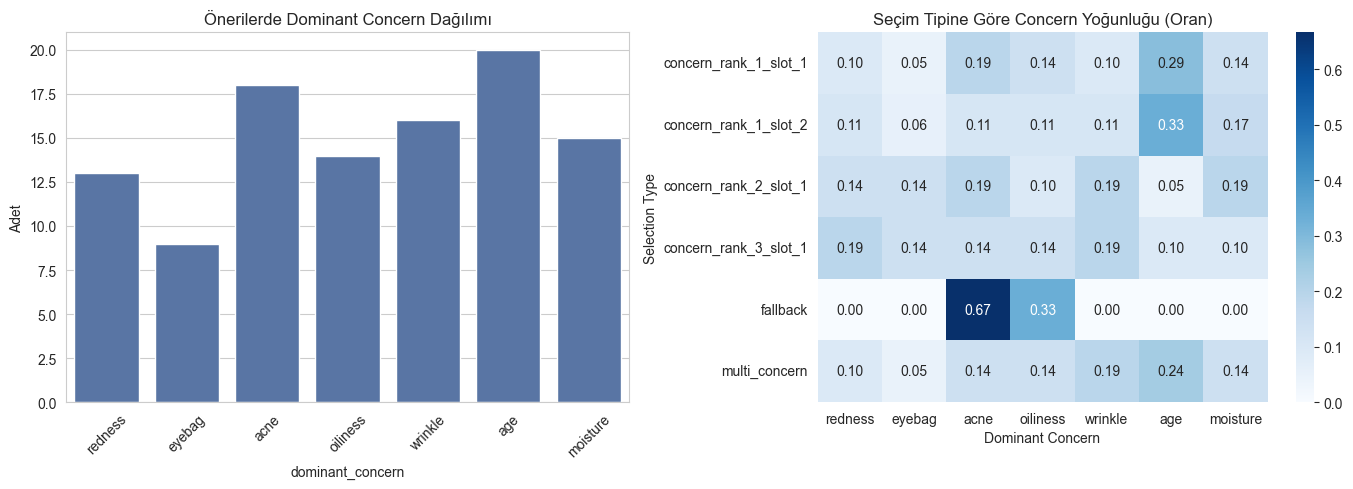

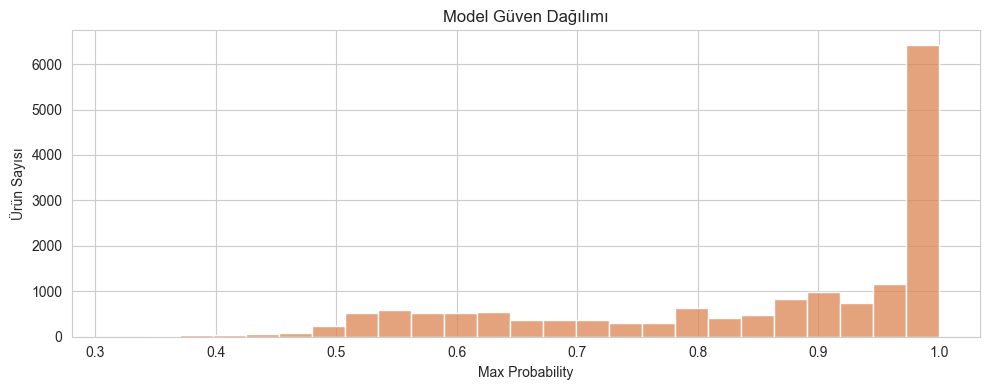

In [21]:
with sns.axes_style('whitegrid'):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    concern_counts = (
        all_recommendations['dominant_concern']
        .value_counts()
        .reindex(CONCERNS, fill_value=0)
    )
    sns.barplot(x=concern_counts.index, y=concern_counts.values, ax=axes[0], color='#4c72b0')
    axes[0].set_title('Önerilerde Dominant Concern Dağılımı')
    axes[0].set_ylabel('Adet')
    axes[0].tick_params(axis='x', rotation=45)

    selection_heatmap = pd.crosstab(
        all_recommendations['selection_type'],
        all_recommendations['dominant_concern'],
        normalize='index'
    ).reindex(columns=CONCERNS, fill_value=0)
    sns.heatmap(selection_heatmap, annot=True, fmt='.2f', cmap='Blues', ax=axes[1])
    axes[1].set_title('Seçim Tipine Göre Concern Yoğunluğu (Oran)')
    axes[1].set_xlabel('Dominant Concern')
    axes[1].set_ylabel('Selection Type')
    plt.tight_layout()

plt.figure(figsize=(10, 4))
sns.histplot(product_profile_df['model_confidence'], bins=25, color='#dd8452')
plt.title('Model Güven Dağılımı')
plt.xlabel('Max Probability')
plt.ylabel('Ürün Sayısı')
plt.tight_layout()

summary = all_recommendations.groupby('user_id')['dominant_concern'].value_counts().unstack(fill_value=0)
summary


## 12. Potansiyel İyileştirmeler

- Gerçek kullanıcı oturumlarından toplanacak vektörlerle sentetik profil seti genişletilebilir.
- Harici INCI sözlükleri entegre edilip güven puanlarıyla ağırlıklandırılarak heuristikler güçlendirilebilir.
- LLM yeniden devreye alınmak istenirse, TF-IDF modelinden gelen güven skorları ile çapraz doğrulama yapılarak hatalı etiketler filtrelenebilir.
